## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json

from scipy.stats import gaussian_kde
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots

In [3]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

model_config = {}
plots_path = ''
dataset_path = ''
stan_file_path = ''
stan_output_dir = ''

#### read models configuration json file

In [4]:
with open("lba_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())

#### Choose and set model configuration

In [5]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config['plots_folder_name'] + '/'
    dataset_path = datasets_root + model_config['dataset_name']
    stan_file_path = stan_files_root + model_config['stan_file']
    stan_output_dir = saved_models_root + model_config['model_name'] + '/'
    os.path
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('LBA', 'LBA_ct', 'LBA_cd', 'LBA_ndm', 'ANN-L…

In [6]:
model_config

{'model_name': 'ANN-LBA_full_s_FC',
 'stan_file': 'ANN-LBA/sigmoid_am_ndm.stan',
 'dataset_name': 'fastText_FC.csv',
 'plots_folder_name': 'ANN-LBA_full_s_FC',
 'transf_params': ['transf_mu_k_word',
  'transf_mu_k_nonword',
  'transf_mu_sp_trial_var_word',
  'transf_mu_sp_trial_var_nonword',
  'transf_mu_g',
  'transf_mu_m',
  'transf_mu_alpha',
  'transf_mu_b',
  'transf_mu_theta_1',
  'transf_mu_theta_2',
  'transf_mu_drift_variability']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,drarp,0,0,0.000000,NW,0.000025,9.999752e-01
1,laud,182,1,2.136932,LF,1.000000,9.540957e-08
2,decremont,0,0,0.000000,NW,0.000771,9.992290e-01
3,gugs,0,0,0.000000,NW,0.000233,9.997666e-01
4,trickery,453,1,2.882899,LF,0.999996,3.610227e-06
...,...,...,...,...,...,...,...
74312,gorphological,0,0,0.000000,NW,0.000168,9.998318e-01
74313,hearse,160,1,3.205648,HF,1.000000,4.410969e-08
74314,appallingly,102,1,1.893894,LF,1.000000,3.650449e-07
74315,furban,0,0,0.000000,NW,0.000531,9.994685e-01


In [8]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,drarp,0,0,0.000000,NW,0.000025,9.999752e-01
1,laud,182,1,2.136932,LF,1.000000,9.540957e-08
2,decremont,0,0,0.000000,NW,0.000771,9.992290e-01
3,gugs,0,0,0.000000,NW,0.000233,9.997666e-01
4,trickery,453,1,2.882899,LF,0.999996,3.610227e-06
...,...,...,...,...,...,...,...
74312,gorphological,0,0,0.000000,NW,0.000168,9.998318e-01
74313,hearse,160,1,3.205648,HF,1.000000,4.410969e-08
74314,appallingly,102,1,1.893894,LF,1.000000,3.650449e-07
74315,furban,0,0,0.000000,NW,0.000531,9.994685e-01


In [9]:
def remove_outliers(df, max_rt, min_rt, std_c=2.5):
    """
    Returns remove outliers from dataframes. Outlier RTs are bigger than
    max_rt and smaller than min_rt. Also RTsthat are out of -/+ (std_c * sd) 
    of mean RT interval are considered as outliers too.

    Parameters
    ----------
        df: pandas dataframe with rt column
        max_rt (float): maximum acceptable rt
        min_rt (float): minimum acceptable rt
        
    Optional Parameters
    ----------
        std_c (float) : Optional
            coefficient to define interval of non-outlier RTs
    
    Returns
    -------
        df: pandas dataframe without outliers  
    """
    mean = df['rt'].mean()
    sd = df['rt'].std()
    lower_thr = mean - std_c*sd
    upper_thr = mean + std_c*sd
    min_bound = max(min_rt, lower_thr)
    max_bound = min(max_rt, upper_thr)
    df = df[df['rt'] >= min_bound]
    df = df[df['rt'] <= max_bound]
    return df

Reading and modifing each behavioral data file and combining all of them into a single behavioral dataframe

In [10]:
Number_Of_Participants = 5
Number_Of_Trials = 400
dataframes = []

for i in range(Number_Of_Participants):
    # Loading each file
    df = pd.read_csv(behavioural_data_root + str(i+1) + "_DATA.LDT", names=['trial', 'string_id', 'string_type', 'accuracy', 'rt', 'string'])
    # Dropping non rows and first two rows that are demographic informations 
    df = df.dropna().drop('string_id', axis=1).drop([0, 1]).iloc[:Number_Of_Trials]
    # Dropping rows with wrong accuracies
    df = df.loc[(df['accuracy'] == '0') | (df['accuracy'] == '1')]
    # Converting columns type to suitable data types
    convert_dict = {'string_type': 'int16',
                    'accuracy': 'int16',
                    'rt': float
                   }

    df = df.astype(convert_dict)
    # Convert RTs to seconds
    df['rt'] = df['rt'].apply(lambda x: x/1000) 
    # Removing Outliers
    df = remove_outliers(df, 3, .2, 2.5)
    # Extracting response of participant from his/her accuracy
    df['response'] = np.logical_not(np.logical_xor(df['string_type'], df['accuracy'])).astype('int')
    df = df.reset_index(drop=True)
    # Particpant number
    df['participant'] = i+1
    # Minimum RT of participant in all trials (is needed for stan code)
    df['minRT'] = df['rt'].min()
    dataframes.append(df)

In [11]:
# Combining dataframes
behavioural_df = pd.concat(dataframes)
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["trial", "string_type", "freq"], axis=1)

In [12]:
behavioural_df.head()

,accuracy,rt,string,response,participant,minRT,label,zipf,category,word_prob,non_word_prob
0,0,0.548,pracker,1,1,0.429,0.0,0.000000,NW,0.000836,9.991643e-01
1,1,0.646,nearside,1,1,0.429,1.0,1.592864,LF,0.998253,1.746930e-03
2,1,0.511,jets,1,1,0.429,1.0,3.645943,HF,1.000000,5.878510e-11
3,1,0.815,vates,0,1,0.429,0.0,0.000000,NW,0.002267,9.977329e-01
4,1,0.680,onward,1,1,0.429,1.0,3.194924,HF,0.999999,1.096722e-06


Predicted probabilities of words and non-words in different conditions in all trials
across participants

In [13]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'non_word_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                        non_word_prob  \
              mean       std count      max           min          mean   
category                                                                  
HF        0.999615  0.003332   345  1.00000  9.458225e-01      0.000385   
LF        0.996585  0.028339   466  1.00000  5.120918e-01      0.003415   
NW        0.002978  0.034298   965  0.99052  5.035976e-23      0.997022   

                                                  
               std count       max           min  
category                                          
HF        0.003332   345  0.054177  9.513443e-20  
LF        0.028339   466  0.487908  2.297777e-14  
NW        0.034298   965  1.000000  9.480231e-03

RT and response description of words and non-words in different conditions in all trials
across participants

In [14]:
behavioural_df.groupby(['category']).agg({'rt': ['mean', 'std', 'max', 'min'], 'response': ['mean', 'std', 'max', 'min']})

rt                          response                  
              mean       std    max    min      mean       std max min
category                                                              
HF        0.805264  0.338597  2.551  0.422  0.968116  0.175947   1   0
LF        0.987938  0.414071  2.861  0.470  0.828326  0.377502   1   0
NW        1.087716  0.453074  2.974  0.446  0.159585  0.366411   1   0

## Stan Model and Estimation

Compiling stan model

In [15]:
lba_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path);

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [16]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df['participant'].to_numpy()                     # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values For models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models

k_priors = [0, 1, 1, 1]                  # All models with LBA
A_priors = [1, 2, 1, 1]                  # All models wtih LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models withoud drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
# There is a k parameter in LBA impelemention so we use theta as k parameter in sigmoid function
theta_priors = [2, 1, 1, 1]              # For models with sigmoid drift mapping functions (ANN-EAM models) (equivalent of k_priors in RDM and ANN-RDM)
sp_trial_var_priors = [1, 1, 0, 1]
drift_variability_priors = [1, 1, 1, 1]

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'k_priors': k_priors,
             'A_priors': A_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             'theta_priors': theta_priors,
             'sp_trial_var_priors': sp_trial_var_priors,
             'drift_variability_priors': drift_variability_priors
             }

# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [17]:
fit = lba_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

14:41:58 - cmdstanpy - INFO - Chain [1] start processing
14:41:58 - cmdstanpy - INFO - Chain [2] start processing


Chain [1] method = sample (Default)Chain [2] method = sample (Default)

Chain [2] sample
Chain [2] num_samples = 250
Chain [2] num_warmup = 250
Chain [2] save_warmup = 0 (Default)
Chain [2] thin = 1 (Default)
Chain [2] adapt
Chain [1] sample
Chain [1] num_samples = 250
Chain [1] num_warmup = 250
Chain [1] save_warmup = 0 (Default)
Chain [2] engaged = 1 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [2] gamma = 0.050000000000000003 (Default)
Chain [2] delta = 0.80000000000000004 (Default)
Chain [2] kappa = 0.75 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [2] t0 = 10 (Default)
Chain [2] init_buffer = 75 (Default)
Chain [2] term_buffer = 50 (Default)
Chain [2] window = 25 (Default)
Chain [1] window = 25 (Default)Chain [2] algorithm = hmc (Defa

14:53:07 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 412.851 seconds (Warm-up)
Chain [1] 256.377 seconds (Sampling)
Chain [1] 669.228 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [2] Iteration: 500 / 500 [100%]  (Sampling)


14:54:00 - cmdstanpy - INFO - Chain [2] done processing
14:54:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Lenovo/AppData/Local/Temp/tmp839i6rvy/tmpgdxzgrwc.stan', line 25, column 8 to column 34) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmp839i6rvy/tmpgdxzgrwc.stan', line 83, column 20 to column 88) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmp839i6rvy/tmpgdxzgrwc.stan', line 286, column 4 to line 287, column 72)
	Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Lenovo/AppData/Local/Temp/tmp839i6rvy/tmpgdxzgrwc.stan', line 25, column 8 to column 34) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmp839i6rvy/tmpgdxzgrwc.stan', line 83, column 20 to column 88) (in 'C:/Users/Lenovo/AppData/Local/Temp/tmp839i6rvy/tmpgdxzgrwc.stan', line 286, column 4 to line 287, column 72)
	Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Lenovo/AppDat

Chain [2] 
Chain [2] Elapsed Time: 416.622 seconds (Warm-up)
Chain [2] 305.237 seconds (Sampling)
Chain [2] 721.859 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 


14:54:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.4%)
	Chain 2 had 1 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


## Model diagnostics

In [18]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan_results\ANN-LBA_full_s_FC\ANN-LBA_full_s_FC-20221007144158_1.csv, D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan_results\ANN-LBA_full_s_FC\ANN-LBA_full_s_FC-20221007144158_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
2 of 500 (0.40%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [19]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-771.505000,0.796153,8.548530,-786.944000,-770.530000,-758.538000,115.289,0.205282,1.005530
mu_k_word,-0.411256,0.025199,0.339125,-0.974732,-0.408794,0.159818,181.115,0.322490,0.999770
mu_k_nonword,0.339404,0.028316,0.462061,-0.428638,0.373264,1.058410,266.284,0.474141,1.008550
mu_sp_trial_var_word,0.939571,0.031150,0.492520,0.109192,0.894865,1.780930,249.990,0.445128,1.004410
mu_sp_trial_var_nonword,1.473860,0.043643,0.589083,0.551205,1.486550,2.471310,182.190,0.324404,1.006300
...,...,...,...,...,...,...,...,...,...
log_lik[1772],-0.489112,0.002756,0.059903,-0.589864,-0.489297,-0.390800,472.272,0.840920,0.998010
log_lik[1773],-0.268616,0.004706,0.100085,-0.422811,-0.270842,-0.105931,452.217,0.805210,0.997215
log_lik[1774],-0.933342,0.003869,0.092216,-1.092200,-0.931121,-0.792227,568.093,1.011540,0.999245
log_lik[1775],0.346155,0.002675,0.066498,0.235740,0.350812,0.446860,618.014,1.100430,0.998461


In [20]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
2847


In [21]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
mu_alpha,0.805949,0.046227,0.535753,-0.072329,0.806183,1.708740,134.318,0.239165,1.02125
mu_theta_1,1.569130,0.037135,0.511885,0.786875,1.555130,2.493900,190.011,0.338330,1.01319
sd_sp_trial_var_word,0.909833,0.023617,0.380401,0.399640,0.865214,1.657120,259.444,0.461961,1.01556
sd_sp_trial_var_nonword,1.210260,0.039931,0.488946,0.529999,1.162620,2.037610,149.936,0.266974,1.03665
sd_alpha,1.254990,0.029392,0.462652,0.649817,1.173860,2.132950,247.774,0.441183,1.02010
...,...,...,...,...,...,...,...,...,...
log_lik[1003],0.254762,0.005721,0.097717,0.102122,0.246565,0.433599,291.776,0.519532,1.01077
log_lik[1028],0.250996,0.005705,0.097680,0.099390,0.243249,0.429002,293.189,0.522047,1.01075
log_lik[1032],0.277618,0.005837,0.098076,0.127117,0.269859,0.460034,282.344,0.502736,1.01079
log_lik[1040],0.201757,0.005460,0.098324,0.045207,0.199936,0.369674,324.249,0.577352,1.01001


In [22]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000,2847.000000
mean,1.737944,0.031949,0.422400,1.097790,1.701490,2.501490,175.691999,0.312834,1.014984
std,0.896891,0.016526,0.225991,0.564665,0.877375,1.312962,32.019770,0.057014,0.003681
min,-2.522490,0.005460,0.097680,-2.857990,-2.510050,-2.237600,134.318000,0.239165,1.010010
25%,0.866046,0.014308,0.181333,0.597776,0.844683,1.203910,160.610000,0.285979,1.012080
50%,1.514800,0.027394,0.370084,0.987283,1.466480,2.173660,161.463000,0.287499,1.014080
75%,2.275620,0.040810,0.518372,1.529850,2.257390,3.116320,182.509000,0.324972,1.017030
max,3.995920,0.071286,0.907528,2.718150,3.928690,5.525790,401.546000,0.714986,1.036650


## Check parameters

Loading Model

In [23]:
# fit = cmdstanpy.from_csv(stan_output_dir)

Parameters posterior plots

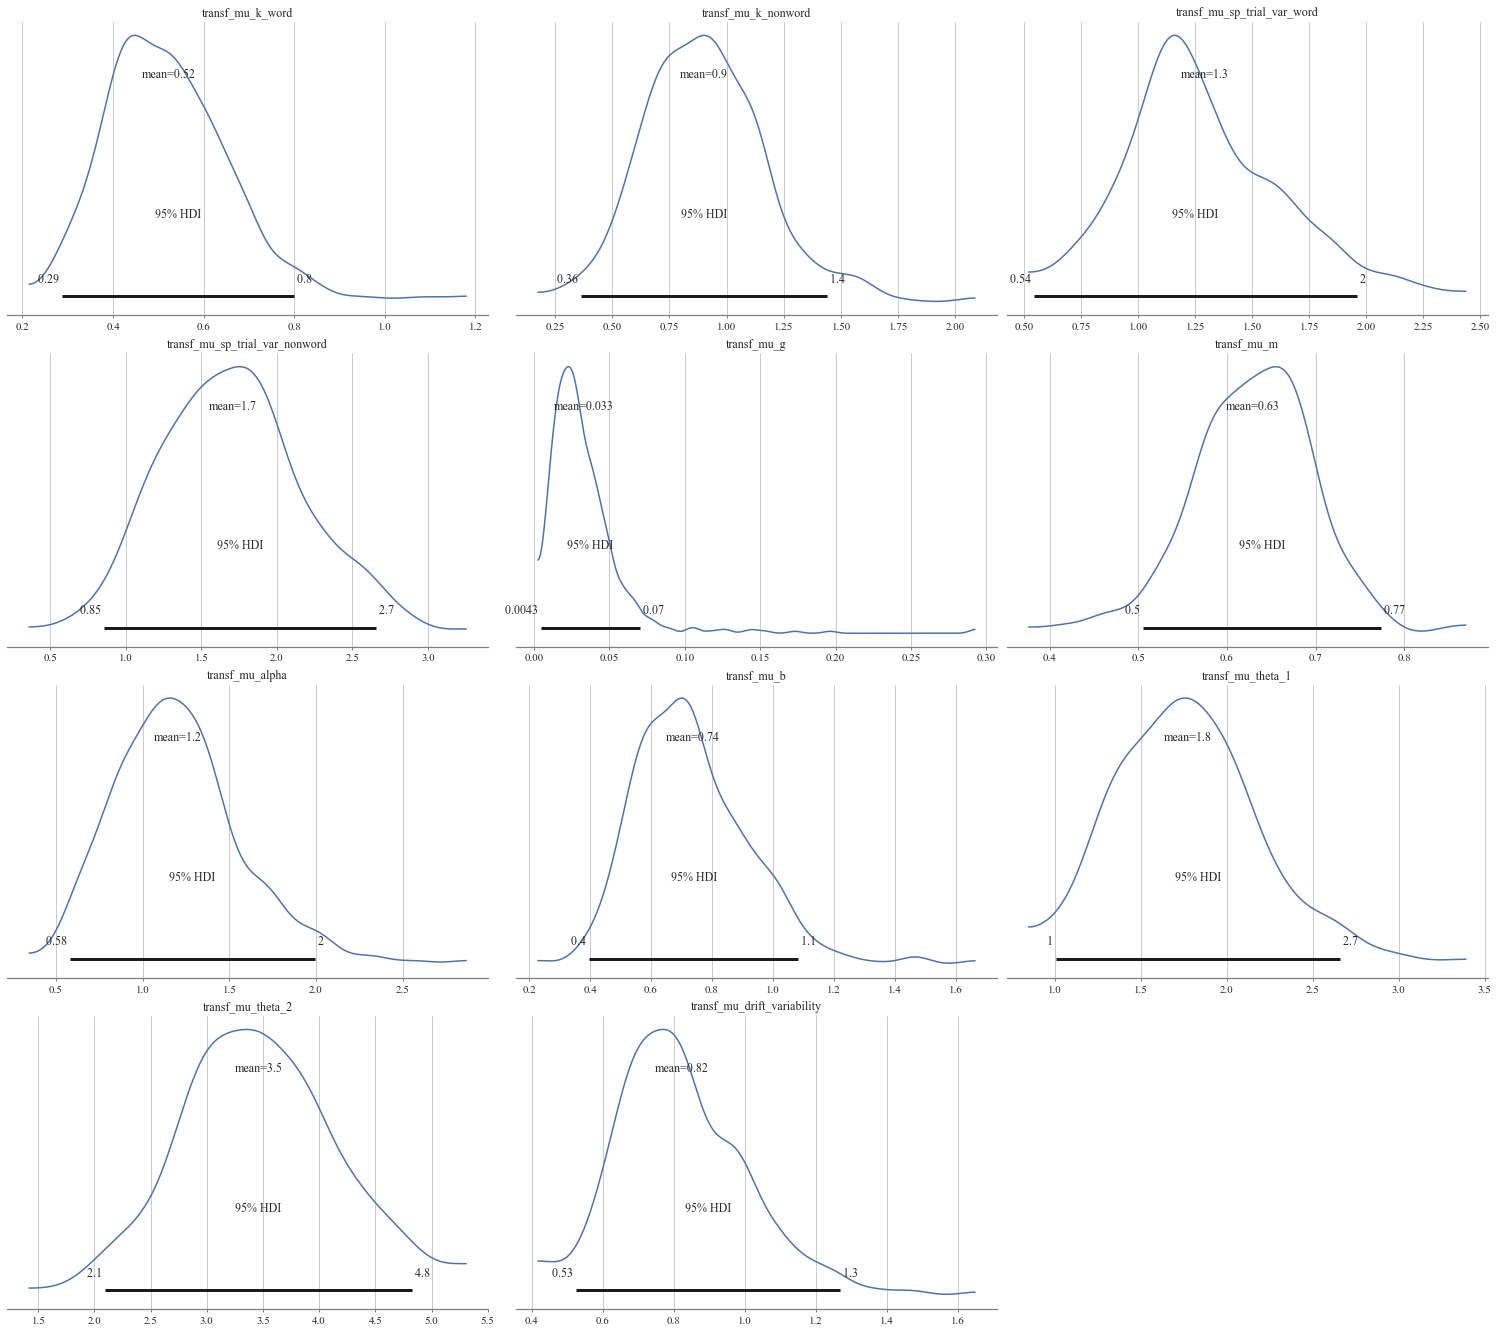

In [24]:
az.plot_posterior(fit, var_names=model_config['transf_params'],
                  hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

Loading model parameters for each trial

In [25]:
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
ndt_t = fit.stan_variables()['ndt_t']
drift_variability_t = fit.stan_variables()['drift_variability_t']
if model_config['model_name'] != "LBA":
    k_t_word = fit.stan_variables()['k_t_word']
    k_t_nonword = fit.stan_variables()['k_t_nonword']
    sp_t_word = fit.stan_variables()['sp_trial_var_t_word']
    sp_t_nonword = fit.stan_variables()['sp_trial_var_t_nonword']

else:
    k_t = fit.stan_variables()['k_t']
    sp_trial_var_t = fit.stan_variables()['sp_trial_var_t']

#### Models mean parameters in different conditions

In [26]:
v_HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
v_HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
v_LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
v_LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
v_NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
v_NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [27]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(v_HF_condition_w, axis=1)), np.std(np.mean(v_HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(v_HF_condition_nw, axis=1)), np.std(np.mean(v_HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(v_LF_condition_w, axis=1)), np.std(np.mean(v_LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(v_LF_condition_nw, axis=1)), np.std(np.mean(v_LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(v_NW_condition_w, axis=1)), np.std(np.mean(v_NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(v_NW_condition_nw, axis=1)), np.std(np.mean(v_NW_condition_nw, axis=1)))

HF words, word drift mean and std:
2.814514007710145 0.5204148257585642
HF words, nonword drift mean and std:
1.3858774751594205 0.277200828847359
LF words word drift mean and std:
2.0325232360343346 0.37239770409021383
LF words nonword drift mean and std:
1.3476160829270385 0.26515700516651247
NW words word drift mean and std:
0.6021429682880829 0.12525165792484735
NW words nonword drift mean and std:
2.6228151491668394 0.4785371870333174


In [28]:
if model_config['model_name'] != "LBA":
    sp_HF_condition_w = sp_t_word[:, behavioural_df['category']=="HF"]
    sp_HF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="HF"]
    sp_LF_condition_w = sp_t_word[:, behavioural_df['category']=="LF"]
    sp_LF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="LF"]
    sp_NW_condition_w = sp_t_word[:, behavioural_df['category']=="NW"]
    sp_NW_condition_nw = sp_t_nonword[:, behavioural_df['category']=="NW"]
else:
    sp_HF_condition = sp_trial_var_t[:, behavioural_df['category']=="HF"]
    sp_LF_condition = sp_trial_var_t[:, behavioural_df['category']=="LF"]
    sp_NW_condition = sp_trial_var_t[:, behavioural_df['category']=="NW"]

In [29]:
if model_config['model_name'] != "LBA":
    print('HF words, word starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_w, axis=1)), np.std(np.mean(sp_HF_condition_w, axis=1)))
    print('HF words, nonword starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_nw, axis=1)), np.std(np.mean(sp_HF_condition_nw, axis=1)))
    print('LF words word starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_w, axis=1)), np.std(np.mean(sp_LF_condition_w, axis=1)))
    print('LF words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_nw, axis=1)), np.std(np.mean(sp_LF_condition_nw, axis=1)))
    print('NW words word starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_w, axis=1)), np.std(np.mean(sp_NW_condition_w, axis=1)))
    print('NW words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_nw, axis=1)), np.std(np.mean(sp_NW_condition_nw, axis=1)))
else:
    print('HF words, starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition, axis=1)), np.std(np.mean(sp_HF_condition, axis=1)))
    print('LF words starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition, axis=1)), np.std(np.mean(sp_LF_condition, axis=1)))
    print('NW words starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition, axis=1)), np.std(np.mean(sp_NW_condition, axis=1)))

HF words, word starting point mean and std:
1.3146794595072462 0.2557497826584091
HF words, nonword starting point mean and std:
1.9327446245976811 0.37350789172722865
LF words word starting point mean and std:
1.3362903194206013 0.25909844639679086
LF words nonword starting point mean and std:
1.9434744887643778 0.371961487686213
NW words word starting point mean and std:
1.312520569456995 0.25503191680717546
NW words nonword starting point mean and std:
1.9080088998182383 0.36611464164750085


In [30]:
if model_config['model_name'] != "LBA":
    k_HF_condition_w = k_t_word[:, behavioural_df['category']=="HF"]
    k_HF_condition_nw = k_t_nonword[:, behavioural_df['category']=="HF"]
    k_LF_condition_w = k_t_word[:, behavioural_df['category']=="LF"]
    k_LF_condition_nw = k_t_nonword[:, behavioural_df['category']=="LF"]
    k_NW_condition_w = k_t_word[:, behavioural_df['category']=="NW"]
    k_NW_condition_nw = k_t_nonword[:, behavioural_df['category']=="NW"]

    t_HF_condition_w = sp_HF_condition_w + sp_HF_condition_w
    t_HF_condition_nw = sp_HF_condition_nw + sp_HF_condition_nw
    t_LF_condition_w = sp_LF_condition_w + sp_LF_condition_w
    t_LF_condition_nw = sp_LF_condition_nw + sp_LF_condition_nw
    t_NW_condition_w = sp_NW_condition_w + sp_NW_condition_w
    t_NW_condition_nw = sp_NW_condition_nw + sp_NW_condition_nw
else:
    k_HF_condition = k_t[:, behavioural_df['category']=="HF"]
    k_LF_condition = k_t[:, behavioural_df['category']=="LF"]
    k_NW_condition = k_t[:, behavioural_df['category']=="NW"]

    t_HF_condition = sp_HF_condition + k_HF_condition
    t_LF_condition = sp_LF_condition + k_LF_condition
    t_NW_condition = sp_NW_condition + k_NW_condition

In [31]:
if model_config['model_name'] != "LBA":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_w, axis=1)), np.std(np.mean(t_HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_nw, axis=1)), np.std(np.mean(t_HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_w, axis=1)), np.std(np.mean(t_LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_nw, axis=1)), np.std(np.mean(t_LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_w, axis=1)), np.std(np.mean(t_NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_nw, axis=1)), np.std(np.mean(t_NW_condition_nw, axis=1)))
else:
    print('HF words,  threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition, axis=1)), np.std(np.mean(t_HF_condition, axis=1)))
    print('LF words threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition, axis=1)), np.std(np.mean(t_LF_condition, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition, axis=1)), np.std(np.mean(t_NW_condition, axis=1)))

HF words, word threshold mean and std:
2.6293589190144924 0.5114995653168182
HF words, nonword threshold mean and std:
3.8654892491953623 0.7470157834544573
LF words word threshold mean and std:
2.6725806388412026 0.5181968927935817
LF words nonword threshold mean and std:
3.8869489775287556 0.743922975372426
NW words word threshold mean and std:
2.62504113891399 0.5100638336143509
NW words nonword threshold mean and std:
3.8160177996364766 0.7322292832950017


In [32]:
if model_config['model_name'] != "LBA":
    bias_HF_condition_w = t_HF_condition_w - sp_HF_condition_w
    bias_HF_condition_nw = t_HF_condition_nw - sp_HF_condition_nw
    bias_LF_condition_w = t_LF_condition_w - sp_LF_condition_w
    bias_LF_condition_nw = t_LF_condition_nw - sp_LF_condition_nw
    bias_NW_condition_w = t_NW_condition_w - sp_NW_condition_w
    bias_NW_condition_nw = t_NW_condition_nw - sp_NW_condition_nw

In [33]:
if model_config['model_name'] != "LBA":
    print('HF words, word bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_w, axis=1)), np.std(np.mean(bias_HF_condition_w, axis=1)))
    print('HF words, nonword bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_nw, axis=1)), np.std(np.mean(bias_HF_condition_nw, axis=1)))
    print('LF words word bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_w, axis=1)), np.std(np.mean(bias_LF_condition_w, axis=1)))
    print('LF words nonword bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_nw, axis=1)), np.std(np.mean(bias_LF_condition_nw, axis=1)))
    print('NW words word bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_w, axis=1)), np.std(np.mean(bias_NW_condition_w, axis=1)))
    print('NW words nonword bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_nw, axis=1)), np.std(np.mean(bias_NW_condition_nw, axis=1)))

HF words, word bias mean and std:
1.3146794595072462 0.2557497826584091
HF words, nonword bias mean and std:
1.9327446245976811 0.37350789172722865
LF words word bias mean and std:
1.3362903194206013 0.25909844639679086
LF words nonword bias mean and std:
1.9434744887643778 0.371961487686213
NW words word bias mean and std:
1.312520569456995 0.25503191680717546
NW words nonword bias mean and std:
1.9080088998182383 0.36611464164750085


In [34]:
ndt_HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
ndt_LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
ndt_NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [35]:
print('HF words ndt mean and std:')
print(np.mean(np.mean(ndt_HF_condition, axis=1)), np.std(np.mean(ndt_HF_condition, axis=1)))
print('LF words ndt mean and std:')
print(np.mean(np.mean(ndt_LF_condition, axis=1)), np.std(np.mean(ndt_LF_condition, axis=1)))
print('Non Words ndt mean and std:')
print(np.mean(np.mean(ndt_NW_condition, axis=1)), np.std(np.mean(ndt_NW_condition, axis=1)))

HF words ndt mean and std:
0.3353426020869565 0.023362781094034
LF words ndt mean and std:
0.34031166445064376 0.02360185308649587
Non Words ndt mean and std:
0.3492868744476682 0.024272948018902795


## Calculating metrics

In [36]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [37]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': -711.9183776052275, 'p_waic': 40.93928859038539, 'waic': 1505.7153323912257, 'waic_se': 99.2448129840753}


## Simulating LBA with estimated parameters

In [38]:
def random_lba_2A(word_drift, nonword_drift, sp_trial_var_word, sp_trial_var_nonword,
                  ndt, k_word, k_nonword, drift_trial_var):
    """Simulates behavior (rt and accuracy) according to the Linear Ballistic Accumulator.
    Parameters
    ----------
    word_drift : numpy.ndarray
        Drift-rate of the Linear Ballistic Accumulator - correct responses. 1D array of floats.
    nonword_drift : numpy.ndarray
        Drift-rate of the Linear Ballistic Accumulator - incorrect responses. 1D array of floats.
    sp_trial_var_word : float
        Starting point variability of the Linear Ballistic Accumulator for words. Also called A.
    sp_trial_var_nonword : float
        Starting point variability of the Linear Ballistic Accumulator for non-words. Also called A.    
    ndt : float
        Non-decision time of the Linear Ballistic Accumulator. Also called tau.
    k_word : float
        Distance between starting point variability and threshold for words.
    k_nonword : float
        Distance between starting point variability and threshold for non-words.
    drift_trial_var : numpy.ndarray, default None
        The drift rate trial variability. 1D array of 0s and 1s.
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Linear Ballistic Accumulator.
        Every element corresponds to the set of parameters given as input with the same shape.
    resp: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response according to the Linear Ballistic Accumulator.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = word_drift.shape
    resp = np.empty(shape)
    rt = np.empty(shape)
    resp[:] = np.nan
    rt[:] = np.nan

    b_word = k_word + sp_trial_var_word
    b_nonword = k_nonword + sp_trial_var_nonword
    one_pose = True
    v_word = np.array(word_drift)
    v_nonword = np.array(nonword_drift)

    # this while loop might be wrong
    while one_pose:
        ind = np.logical_and(v_word < 0, v_nonword < 0)
        if drift_trial_var is None:
            v_word[ind] = np.random.normal(word_drift[ind], np.ones(word_drift[ind].shape))
            v_nonword[ind] = np.random.normal(nonword_drift[ind], np.ones(nonword_drift[ind].shape))
        else:
            v_word[ind] = np.random.normal(word_drift[ind], drift_trial_var[ind])
            v_nonword[ind] = np.random.normal(nonword_drift[ind], drift_trial_var[ind])

        one_pose = np.sum(ind) > 0

    start_word = np.random.uniform(np.zeros(sp_trial_var_word.shape), sp_trial_var_word)
    start_non_word = np.random.uniform(np.zeros(sp_trial_var_nonword.shape), sp_trial_var_nonword)

    ttf_word = (b_word - start_word) / v_word
    ttf_nonword = (b_nonword - start_non_word) / v_nonword

    ind = np.logical_and(ttf_word <= ttf_nonword, 0 < ttf_word)
    resp[ind] = 1
    rt[ind] = ttf_word[ind] + ndt[ind]

    ind = np.logical_and(ttf_nonword < 0, 0 < ttf_word)
    resp[ind] = 1
    rt[ind] = ttf_word[ind] + ndt[ind]

    ind = np.logical_and(ttf_nonword < ttf_word, 0 < ttf_nonword)
    resp[ind] = 0
    rt[ind] = ttf_nonword[ind] + ndt[ind]

    ind = np.logical_and(ttf_word < 0, 0 < ttf_nonword)
    resp[ind] = 0
    rt[ind] = ttf_nonword[ind] + ndt[ind]

    return rt, resp

Simulating RDM with estimated parameters

In [39]:
if model_config['model_name'] != "LBA":
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_t_word, sp_t_nonword,
                                       ndt_t, k_t_word, k_t_nonword, drift_variability_t)
else:
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_trial_var_t, sp_trial_var_t,
                                       ndt_t, k_t, k_t, drift_variability_t)

In [40]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [41]:
# Predicted Data
rt_predictions = pd.concat((pd.DataFrame(pp_rt, index=pd.Index(np.arange(1, len(pp_rt)+1))).T, behavioural_df['category']), axis=1)
response_predictions = pd.concat((pd.DataFrame(pp_response, index=pd.Index(np.arange(1, len(pp_response)+1))).T, behavioural_df['category']), axis=1)

# Experiment Data
experiment_data = behavioural_df.loc[:, ['rt', 'response', 'category']]

Separating RT and Response of predicted and experimental data for each condition

In [42]:
HF_data = experiment_data.loc[experiment_data['category']=='HF']
LF_data = experiment_data.loc[experiment_data['category']=='LF']
NW_data = experiment_data.loc[experiment_data['category']=='NW']

HF_pred_rt = rt_predictions.loc[rt_predictions['category']=='HF'].drop(['category'], axis=1)
HF_pred_resp = response_predictions.loc[response_predictions['category']=='HF'].drop(['category'], axis=1)
LF_pred_rt = rt_predictions.loc[rt_predictions['category']=='LF'].drop(['category'], axis=1)
LF_pred_resp = response_predictions.loc[response_predictions['category']=='LF'].drop(['category'], axis=1)
NW_pred_rt = rt_predictions.loc[rt_predictions['category']=='NW'].drop(['category'], axis=1)
NW_pred_resp = response_predictions.loc[response_predictions['category']=='NW'].drop(['category'], axis=1)

## Quantiles Posterior Predictions

In [43]:
quantiles = [.1, .3, .5, .7, .9]
percentiles = np.array(quantiles)*100

In [44]:
# experiment Data quantile
HF_quantile_ex = HF_data['rt'].quantile(quantiles)
LF_quantile_ex = LF_data['rt'].quantile(quantiles)
NW_quantile_ex = NW_data['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = HF_pred_rt.quantile(quantiles, axis=0).T
LF_quantile_pred = LF_pred_rt.quantile(quantiles, axis=0).T
NW_quantile_pred = NW_pred_rt.quantile(quantiles, axis=0).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

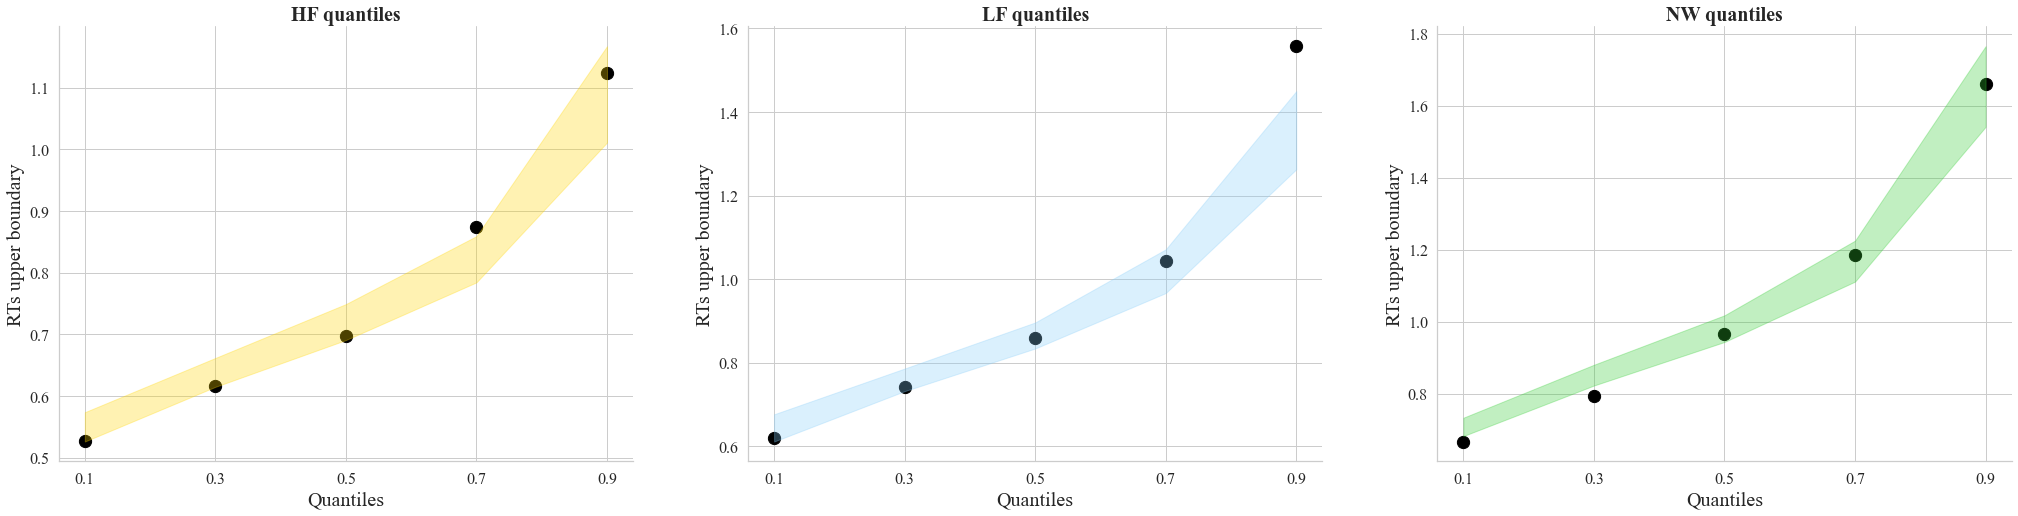

In [45]:
fig, axes = plt.subplots(1,3 , figsize=(35,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=150)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=150)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=150)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=20)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=20)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(16)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 

sns.despine()
plt.savefig(plots_path + 'Quantiles Poseterior.pdf')

## Mean Accuracy and RT Posterior Plots

In [46]:
HF_data_rt_mean = HF_data['rt'].mean()
LF_data_rt_mean = LF_data['rt'].mean()
NW_data_rt_mean = NW_data['rt'].mean()

HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
NW_pred_rt_mean = NW_pred_rt.mean(axis=0)


HF_data_resp_mean = HF_data['response'].mean()
LF_data_resp_mean = LF_data['response'].mean()
NW_data_resp_mean = NW_data['response'].mean()

HF_pred_resp_mean = HF_pred_resp.mean(axis=0)
LF_pred_resp_mean = LF_pred_resp.mean(axis=0)
NW_pred_resp_mean = NW_pred_resp.mean(axis=0)


In [47]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)], color = 'lightsteelblue')

    ax.plot(xd, yd, color='slategray')
    ax.axvline(data_mean, color='red')

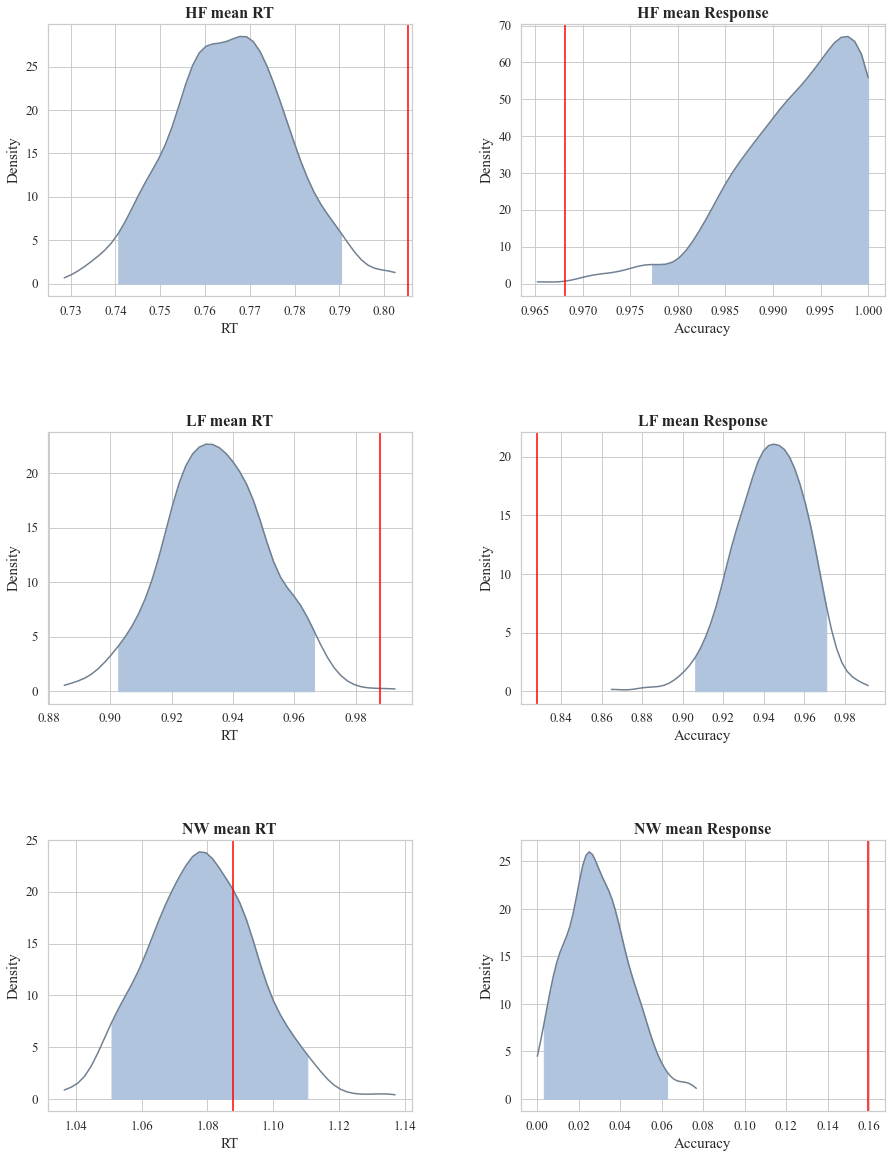

In [48]:
fig, axes = plt.subplots(3,2 , figsize=(15,20))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label.set_fontsize(13) 

plt.savefig(plots_path + 'Mean Accuracy and RT.pdf')